In [1]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from math import radians, cos, sin, sqrt, atan2
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import folium
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display_html
from tabulate import tabulate


In [2]:
# Load the datasets
df1 = pd.read_csv("Datasets/hotels.csv", on_bad_lines='skip')
df2 = pd.read_csv("Datasets/places.csv")
df3 = pd.read_csv("Datasets/restaurants.csv")

print("Dataset df1 loaded with shape:", df1.shape)
print("Dataset df2 loaded with shape:", df2.shape)
print("Dataset df3 loaded with shape:", df3.shape)

Dataset df1 loaded with shape: (20046, 33)
Dataset df2 loaded with shape: (325, 10)
Dataset df3 loaded with shape: (2306, 10)


In [3]:
# Preprocessing df1
columns_to_drop = [
    'in_your_room', 'is_value_plus', "pageurl", "query_time_stamp",
    "image_urls", "qts", "site_review_count","mmt_review_rating",
    'crawl_date', 'highlight_value', "hotel_overview",
    "mmt_holidayiq_review_count", 'sitename', 'state'
]

# Dropping columns that exist and ignoring those that don't
df1.drop(columns=columns_to_drop, axis=1, inplace=True, errors='ignore')

# Replacing and converting hotel star ratings to numeric values
df1["hotel_star_rating"] = df1["hotel_star_rating"].replace(
    {"1 star": 1, "2 star": 2, "3 star": 3, "4 star": 4, "5 star": 5, 
     "Four star": 4, "Three on 5": 3, "Four on 5": 4, "Five on 5": 5}
).fillna(0).astype(float)

# Filling missing values in important columns
df1['site_review_rating'] = pd.to_numeric(df1['site_review_rating'], errors='coerce').fillna(0)
df1["traveller_rating"] = pd.to_numeric(df1["traveller_rating"], errors='coerce').fillna(0)
df1["country"] = df1.property_type.fillna("India")
df1["area"] = df1.area.fillna(df1["city"])
df1["property_type"] = df1.property_type.fillna("Hotel")
df1["room_types"] = df1.room_types.fillna("Standard Room")
df1["room_types"] = df1["room_types"].str.replace('`', '', regex=False).str.replace('|', ', ', regex=False).str.title()

# Replace '..' and empty strings with NaN
df1.replace(['..', ''], np.nan, inplace=True)

# Removing rows with missing property addresses
df1 = df1.loc[~df1["property_address"].isnull()]

# Reset index
df1.reset_index(drop=True, inplace=True)

# Ensure 'mmt_review_score' is numeric (replacing 'mmt_review_rating' with 'mmt_review_score')
df1["mmt_review_score"] = pd.to_numeric(df1["mmt_review_score"], errors='coerce').fillna(0)

# Shuffling data and renaming columns
df1 = df1.sample(frac=1, random_state=42).reset_index(drop=True)
df1.rename(columns={
    'property_name': 'Hotel Name',
    'area': 'Area',
    'mmt_review_score': 'Review',
    'room_types': 'Room Types',
}, inplace=True)

print("After preprocessing, df1 shape:", df1.shape)
df1.head()


After preprocessing, df1 shape: (20042, 19)


,Area,city,country,hotel_star_rating,latitude,longitude,mmt_location_rating,mmt_review_count,Review,mmt_traveller_type_review_count,mmt_tripadvisor_count,property_address,property_id,Hotel Name,property_type,Room Types,site_review_rating,traveller_rating,uniq_id
0,Near Toll Post,Pahalgam,Hotel,2.0,0.0000,0.0000,3.4,5.0,3.0,Families:4|Couples:1|Business:0|Solo:0|Friends:0,NaN,"Near Toll Plaza , Near Toll Plaza",201404051524178444&i=,The Meadows (Krimzon),Hotel,Superior,0.0,0.0,22d89e364ccc1b574f3557a3b11c13f1
1,Karol Bagh,New Delhi And NCR,Hotel,3.0,28.6460,77.1830,Location:4.3,23.0,0.0,Family:5|Couple:3|Solo:4|Friends:0|Business:0,58.0,"7 A/36, W.E.A, Channa Market, Karol Bagh Karo...",201406242027399761,Hotel Shimla Heritage,Hotel,"Deluxe Room, Deluxe Room With Balcony",3.7,4.0,0b143825723830809645f31f73f983eb
2,Wayanad,Wayanad,Hotel,1.0,0.0000,0.0000,NaN,0.0,0.0,Families:0|Couples:0|Business:0|Solo:0|Friends:0,NaN,"Rest And Peace, Kalpetta ,",201411131519046864&i=,Rest And Peace Homestay,Hotel,Standard,0.0,0.0,630c059acfe07104e3d48982db334191
3,Hunsur Road,Mysore,Hotel,4.0,12.3121,76.6405,NaN,NaN,4.4,Families:{{ratingSummaryInfo.miscMap['family']...,249.0,"The Quorum Hotel , 2257/1, Vinobha road, Mysor...",201304231650358754,The Quorum,Hotel,Standard Room,0.0,0.0,6d5a31bb48add2c69e2dc736dca4f50b
4,Golden Temple,Amritsar,Hotel,1.0,31.6218,74.8754,NaN,0.0,0.0,Families:0|Couples:0|Business:0|Solo:0|Friends:0,87.0,"Bazar Mai Sewan, Near Golden , Temple Amritsar",201412271151192236,Hotel Darbar View,Hotel,Deluxe,0.0,0.0,b102c8eac2220141de036de84d169fdb


In [4]:
# Preprocessing df2
df2['Type'] = df2['Type'].fillna('Unknown')
df2['Google review rating'] = pd.to_numeric(df2['Google review rating'], errors='coerce')
df2['Number of google review in lakhs'] = pd.to_numeric(df2['Number of google review in lakhs'], errors='coerce')
df2.dropna(subset=['Google review rating', 'Number of google review in lakhs', 'latitude', 'longitude'], inplace=True)
df2.reset_index(drop=True, inplace=True)

df2 = df2.sample(frac=1, random_state=42).reset_index(drop=True)

print("After preprocessing, df2 shape:", df2.shape)
df2.head()


After preprocessing, df2 shape: (325, 10)


,State,City,Name,Type,Google review rating,Significance,Number of google review in lakhs,Best Time to visit,latitude,longitude
0,Sikkim,Gangtok,Baba Harbhajan Singh Temple,Temple,4.7,Religious,0.075,All,27.365876,88.837889
1,Jammu and Kashmir,Jammu,Vaishno Devi,Temple,4.7,Religious,0.550,All,33.027399,74.945375
2,Tamil Nadu,Madurai,Meenakshi Amman Temple,Temple,4.7,Religious,0.650,All,9.919543,78.118833
3,Andhra Pradesh,Visakhapatnam,Matsyadarshini Aquarium,Aquarium,3.8,Recreational,0.030,All,17.712852,83.319906
4,Himachal Pradesh,Manikaran,Manikaran Sahib,Gurudwara,4.6,Religious,1.300,Morning,32.026924,77.344907


In [5]:
# Preprocessing df3 (restaurants)
df3['Rating'] = pd.to_numeric(df3['Rating'], errors='coerce').fillna(0)
df3['Votes'] = pd.to_numeric(df3['Votes'], errors='coerce').fillna(0)
df3['Average-Cost'] = pd.to_numeric(df3['Average-Cost'], errors='coerce').fillna(0)
df3.dropna(subset=['Latitude', 'Longitude'], inplace=True)
df3.reset_index(drop=True, inplace=True)

df3 = df3.sample(frac=1, random_state=42).reset_index(drop=True)

print("After preprocessing, df3 shape:", df3.shape)
df3.head()

After preprocessing, df3 shape: (2306, 10)


,Name,Location,Locality,City,Cuisine,Rating,Votes,Average-Cost,Latitude,Longitude
0,Dildaar,"Madhapur, West Hyderabad",West Hyderabad,Hyderabad,"North Indian, Mughlai",4.3,187,1000,17.440892,78.391630
1,Cinch,"Raj Nagar, Ghaziabad",Ghaziabad,Ghaziabad,"Multi-Cuisine, North Indian, Italian, Chine...",3.9,62,2200,28.681862,77.446116
2,Zero Lounge,"B B D Bagh, Central Kolkata",Central Kolkata,Kolkata,"North Indian, Chinese, Mughlai",4.4,24,1500,22.573954,88.345015
3,Creme Borne,"Connaught Place, Central Delhi",Central Delhi,Delhi,"Desserts, Ice Cream, Fast Food",4.8,9,500,28.618592,77.210780
4,Hawte,"Madhapur, West Hyderabad",West Hyderabad,Hyderabad,"Desserts, Ice Cream, Shakes",4.3,17,400,17.440892,78.391630


In [6]:
# Function to determine the optimal number of clusters using the Elbow Method
def determine_optimal_clusters(data, max_k=10, plot_title="Elbow Method"):
    inertias = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)
    
    # Plot the Elbow Curve
    plt.figure(figsize=(8, 3))
    plt.plot(range(1, max_k + 1), inertias, marker='o')
    plt.title(plot_title)
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.xticks(range(1, max_k + 1))
    plt.grid(True)
    plt.show()


Scaled hotel features shape: (20042, 5)


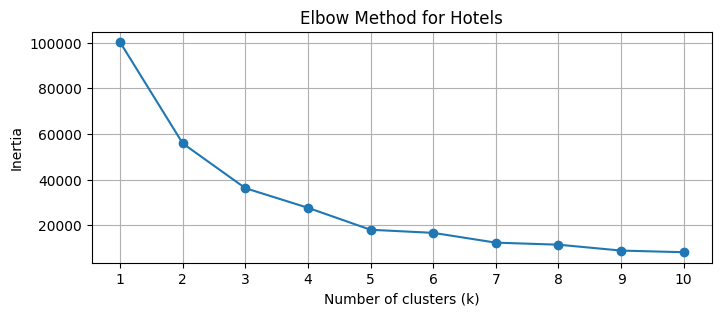

Hotel clusters assigned. Cluster distribution:
hotel_cluster
3    11120
0     4359
1     3986
4      480
2       97
Name: count, dtype: int64


In [7]:
# Function to prepare hotel data for clustering
def prepare_hotel_data(hotel_df):
    # Select relevant features
    hotel_features = hotel_df[['hotel_star_rating', 'Review', 
                               'mmt_review_count', 'Review', 'traveller_rating']]
    
    # Handle any remaining missing values by filling with 0
    hotel_features = hotel_features.fillna(0)
    
    # Initialize the scaler
    scaler = StandardScaler()
    
    # Fit and transform the data
    scaled_hotel_features = scaler.fit_transform(hotel_features)
    
    return scaled_hotel_features, scaler

# Prepare hotel data
scaled_hotel_features, hotel_scaler = prepare_hotel_data(df1)
print("Scaled hotel features shape:", scaled_hotel_features.shape)

determine_optimal_clusters(scaled_hotel_features, max_k=10, plot_title="Elbow Method for Hotels")

k_hotel = 5
kmeans_hotel = KMeans(n_clusters=k_hotel, random_state=42)
df1['hotel_cluster'] = kmeans_hotel.fit_predict(scaled_hotel_features)

print("Hotel clusters assigned. Cluster distribution:")
print(df1['hotel_cluster'].value_counts())




Scaled place features shape: (325, 4)


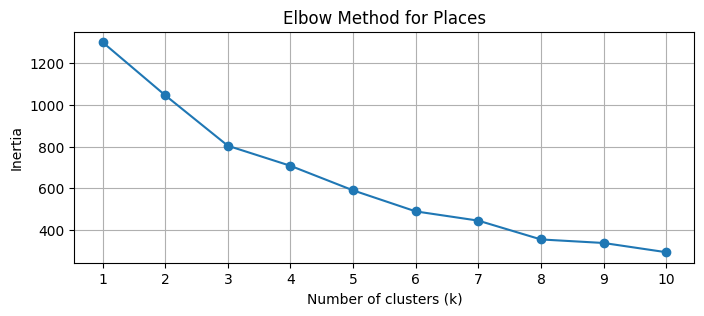

Place clusters assigned. Cluster distribution:
place_cluster
2    135
0    112
1     78
Name: count, dtype: int64


In [8]:
# Function to prepare place data for clustering
def prepare_place_data(places_df):
    # Select relevant features
    place_features = places_df[['Google review rating', 'Number of google review in lakhs', 
                                'latitude', 'longitude']]
    
    # Handle any remaining missing values by filling with 0
    place_features = place_features.fillna(0)
    
    # Initialize the scaler
    scaler = StandardScaler()
    
    # Fit and transform the data
    scaled_place_features = scaler.fit_transform(place_features)
    
    return scaled_place_features, scaler

# Prepare place data
scaled_place_features, place_scaler = prepare_place_data(df2)
print("Scaled place features shape:", scaled_place_features.shape)

# Determine optimal clusters for places
determine_optimal_clusters(scaled_place_features, max_k=10, plot_title="Elbow Method for Places")

# Applying K-Means to Places
k_place = 3
kmeans_place = KMeans(n_clusters=k_place, random_state=42)
df2['place_cluster'] = kmeans_place.fit_predict(scaled_place_features)

print("Place clusters assigned. Cluster distribution:")
print(df2['place_cluster'].value_counts())


Scaled restaurant features shape: (2306, 5)


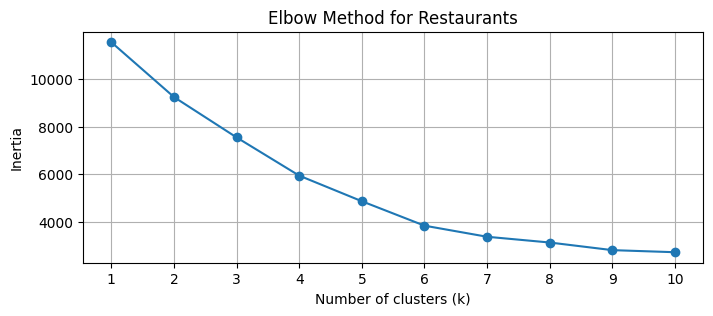

Restaurant clusters assigned. Cluster distribution:
restaurant_cluster
1    1105
0     580
2     380
3     241
Name: count, dtype: int64


In [9]:
# Function to prepare restaurant data for clustering
def prepare_restaurant_data(restaurant_df):
    # Select relevant features
    restaurant_features = restaurant_df[['Rating', 'Votes', 'Average-Cost', 'Latitude', 'Longitude']]
    
    # Handle any remaining missing values by filling with 0
    restaurant_features = restaurant_features.fillna(0)
    
    # Initialize the scaler
    scaler = StandardScaler()
    
    # Fit and transform the data
    scaled_restaurant_features = scaler.fit_transform(restaurant_features)
    
    return scaled_restaurant_features, scaler

# Prepare restaurant data
scaled_restaurant_features, restaurant_scaler = prepare_restaurant_data(df3)
print("Scaled restaurant features shape:", scaled_restaurant_features.shape)

# Determine optimal clusters for restaurants
determine_optimal_clusters(scaled_restaurant_features, max_k=10, plot_title="Elbow Method for Restaurants")

# Applying K-Means to Restaurants
k_restaurant = 4
kmeans_restaurant = KMeans(n_clusters=k_restaurant, random_state=42)
df3['restaurant_cluster'] = kmeans_restaurant.fit_predict(scaled_restaurant_features)

print("Restaurant clusters assigned. Cluster distribution:")
print(df3['restaurant_cluster'].value_counts())


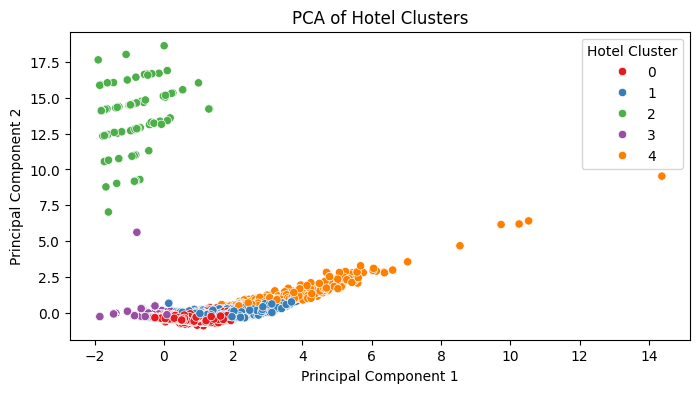

In [10]:
# Function to apply PCA and reduce dimensions
def apply_pca(data, n_components=2):
    pca = PCA(n_components=n_components, random_state=42)
    principal_components = pca.fit_transform(data)
    return principal_components, pca

# Apply PCA to hotel data
pca_hotel, hotel_pca_model = apply_pca(scaled_hotel_features, n_components=2)

# Plot PCA results for hotels
plt.figure(figsize=(8,4))
sns.scatterplot(x=pca_hotel[:,0], y=pca_hotel[:,1], hue=df1['hotel_cluster'], palette='Set1', legend='full')
plt.title("PCA of Hotel Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Hotel Cluster')
plt.show()

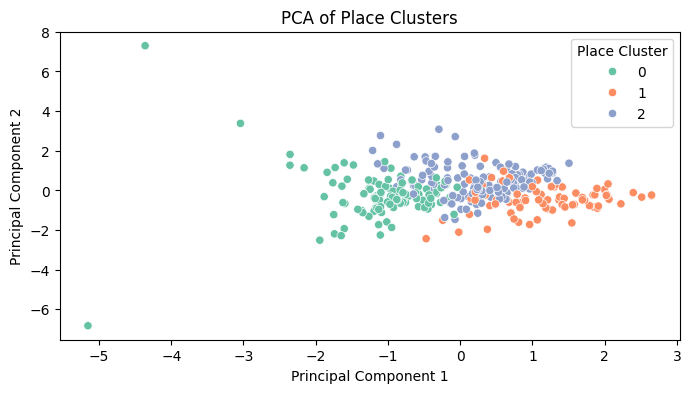

In [11]:
# Apply PCA to place data
pca_place, place_pca_model = apply_pca(scaled_place_features, n_components=2)

# Plot PCA results for places
plt.figure(figsize=(8,4))
sns.scatterplot(x=pca_place[:,0], y=pca_place[:,1], hue=df2['place_cluster'], palette='Set2', legend='full')
plt.title("PCA of Place Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Place Cluster')
plt.show()


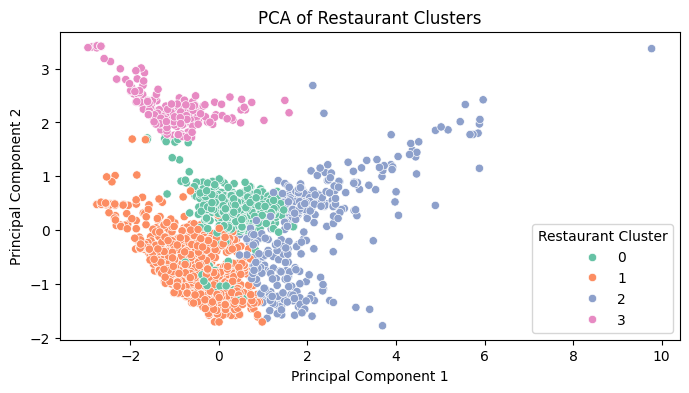

In [12]:
# Apply PCA to place data
pca_restuarant, restuarant_pca_model = apply_pca(scaled_restaurant_features, n_components=2)

# Plot PCA results for restuarants
plt.figure(figsize=(8,4))
sns.scatterplot(x=pca_restuarant[:,0], y=pca_restuarant[:,1], hue=df3['restaurant_cluster'], palette='Set2', legend='full')
plt.title("PCA of Restaurant Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Restaurant Cluster')
plt.show()

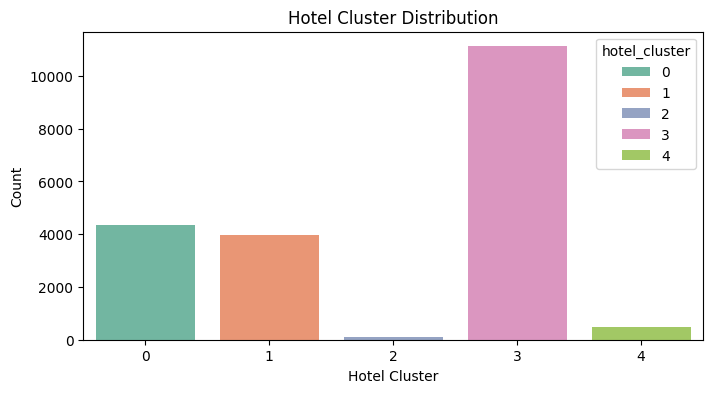

In [13]:
plt.figure(figsize=(8,4))
sns.countplot(x='hotel_cluster', data=df1, hue='hotel_cluster', palette='Set2')
plt.title('Hotel Cluster Distribution')
plt.xlabel('Hotel Cluster')
plt.ylabel('Count')
plt.show()

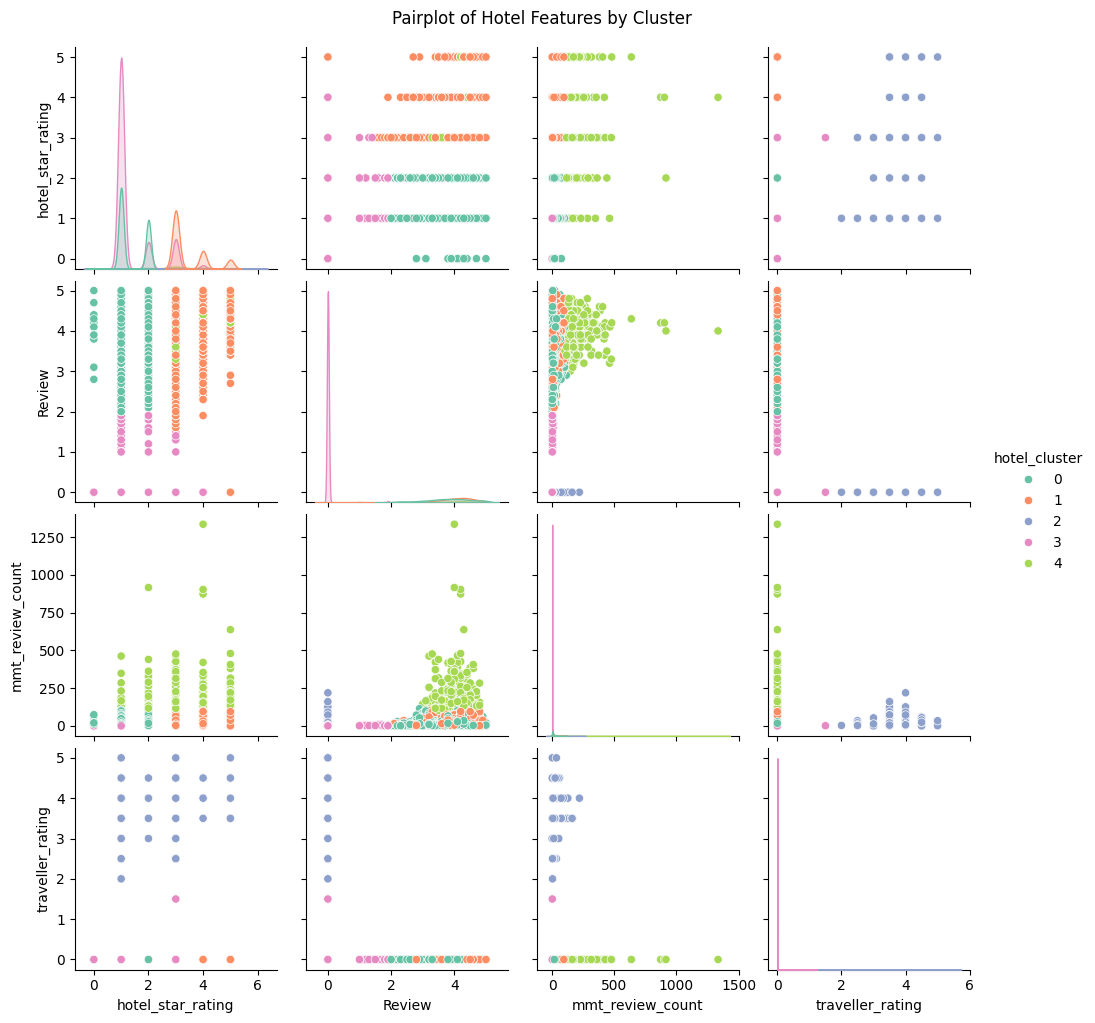

In [14]:
sns.pairplot(df1[['hotel_star_rating', 'Review', 'mmt_review_count', 'traveller_rating', 'hotel_cluster']], hue='hotel_cluster', palette='Set2')
plt.suptitle('Pairplot of Hotel Features by Cluster', y=1.02)
plt.show()

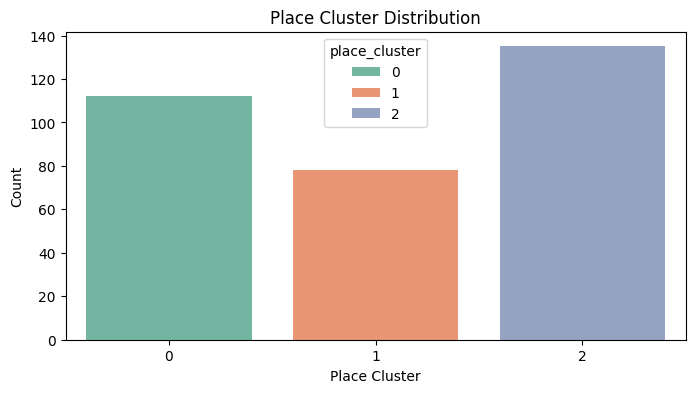

In [15]:
plt.figure(figsize=(8,4))
sns.countplot(x='place_cluster', data=df2, hue='place_cluster', palette='Set2')
plt.title('Place Cluster Distribution')
plt.xlabel('Place Cluster')
plt.ylabel('Count')
plt.show()

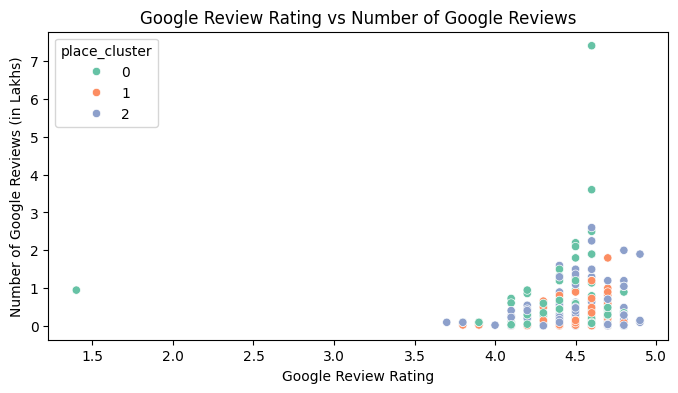

In [16]:
plt.figure(figsize=(8, 4))
sns.scatterplot(x='Google review rating', y='Number of google review in lakhs', hue='place_cluster', palette='Set2', data=df2)
plt.title('Google Review Rating vs Number of Google Reviews')
plt.xlabel('Google Review Rating')
plt.ylabel('Number of Google Reviews (in Lakhs)')
plt.show()

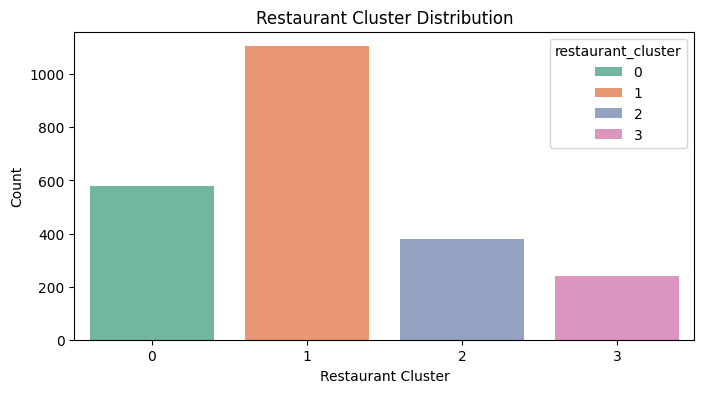

In [17]:
plt.figure(figsize=(8,4))
sns.countplot(x='restaurant_cluster', data=df3, hue='restaurant_cluster', palette='Set2')
plt.title('Restaurant Cluster Distribution')
plt.xlabel('Restaurant Cluster')
plt.ylabel('Count')
plt.show()

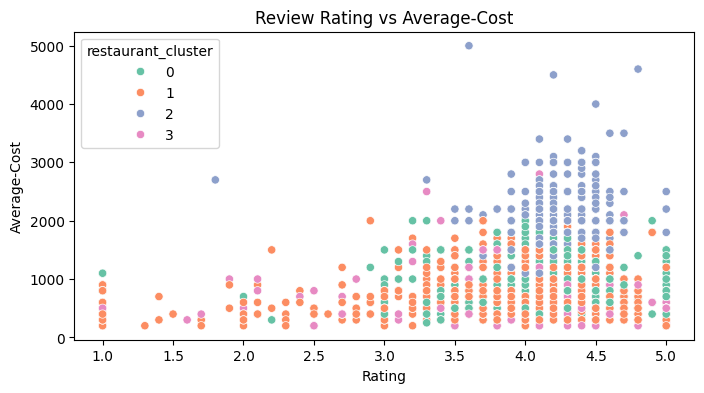

In [18]:
plt.figure(figsize=(8, 4))
sns.scatterplot(x='Rating', y='Average-Cost', hue='restaurant_cluster', palette='Set2', data=df3)
plt.title('Review Rating vs Average-Cost')
plt.xlabel('Rating')
plt.ylabel('Average-Cost')
plt.show()

In [19]:
# Haversine function
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    
    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    distance = R * c
    return distance

In [20]:
# Geocoding function with caching
geocode_cache = {}

def get_coordinates(place_name):
    if place_name in geocode_cache:
        return geocode_cache[place_name]
    
    geolocator = Nominatim(user_agent="hotel_place_restaurant_recommender")
    try:
        location = geolocator.geocode(place_name)
        if location:
            geocode_cache[place_name] = (location.latitude, location.longitude)
            return location.latitude, location.longitude
        else:
            return None, None
    except GeocoderTimedOut:
        print("Geocoding timed out. Retrying...")
        return get_coordinates(place_name)  # Retry on timeout
    

# Test geocoding function
test_place = "Mumbai"
lat, lon = get_coordinates(test_place)
print(f"Coordinates of {test_place}: Latitude={lat}, Longitude={lon}")


Coordinates of Mumbai: Latitude=19.0785451, Longitude=72.878176


In [21]:
# Updated recommend_hotels function with clustering and using 'mmt_review_score'
def recommend_hotels(user_lat, user_lon, hotel_df, radius_km=50, top_n=10):
    # Calculate distance for each hotel
    hotel_df['distance'] = hotel_df.apply(
        lambda row: haversine(user_lat, user_lon, row['latitude'], row['longitude']), axis=1
    )
    
    # Filter hotels within the radius and create an explicit copy
    nearby_hotels = hotel_df[hotel_df['distance'] <= radius_km].copy()
    
    # Ensure numeric types
    nearby_hotels.loc[:, 'Review'] = pd.to_numeric(
        nearby_hotels['Review'], errors='coerce'
    ).fillna(0)
    
    nearby_hotels.loc[:, 'mmt_review_count'] = pd.to_numeric(
        nearby_hotels['mmt_review_count'], errors='coerce'
    ).fillna(0)
    
    nearby_hotels.loc[:, 'hotel_star_rating'] = pd.to_numeric(
        nearby_hotels['hotel_star_rating'], errors='coerce'
    ).fillna(0)
    
    # Sort by review score, review count, and star rating
    nearby_hotels.sort_values(
        by=['Review', 'mmt_review_count', 'hotel_star_rating'], 
        ascending=False, inplace=True
    )
    
    # Get unique clusters
    clusters = nearby_hotels['hotel_cluster'].unique()
    
    # Determine how many hotels per cluster
    hotels_per_cluster = max(1, top_n // len(clusters))
    
    recommended_hotels = pd.DataFrame()
    
    for cluster in clusters:
        cluster_hotels = nearby_hotels[nearby_hotels['hotel_cluster'] == cluster].head(hotels_per_cluster)
        recommended_hotels = pd.concat([recommended_hotels, cluster_hotels])
    
    # If not enough hotels, fill the rest with top remaining
    if len(recommended_hotels) < top_n:
        remaining = top_n - len(recommended_hotels)
        additional_hotels = nearby_hotels[~nearby_hotels.index.isin(recommended_hotels.index)].head(remaining)
        recommended_hotels = pd.concat([recommended_hotels, additional_hotels])
    
    return recommended_hotels.head(top_n)


In [22]:
# Updated recommend_places function with clustering
def recommend_places(user_lat, user_lon, places_df, radius_km=50, top_n=10):
    # Calculate distance for each place
    places_df['distance'] = places_df.apply(
        lambda row: haversine(user_lat, user_lon, row['latitude'], row['longitude']), axis=1
    )
    
    # Filter places within the radius and create an explicit copy
    nearby_places = places_df[places_df['distance'] <= radius_km].copy()
    
    # Ensure numeric types
    nearby_places.loc[:, 'Google review rating'] = pd.to_numeric(
        nearby_places['Google review rating'], errors='coerce'
    ).fillna(0)
    
    nearby_places.loc[:, 'Number of google review in lakhs'] = pd.to_numeric(
        nearby_places['Number of google review in lakhs'], errors='coerce'
    ).fillna(0)
    
    # Sort by Google review rating and number of reviews
    nearby_places.sort_values(
        by=['Google review rating', 'Number of google review in lakhs'], 
        ascending=False, inplace=True
    )
    
    # Get unique clusters
    clusters = nearby_places['place_cluster'].unique()
    
    # Determine how many places per cluster
    places_per_cluster = max(1, top_n // len(clusters))
    
    recommended_places = pd.DataFrame()
    
    for cluster in clusters:
        cluster_places = nearby_places[nearby_places['place_cluster'] == cluster].head(places_per_cluster)
        recommended_places = pd.concat([recommended_places, cluster_places])
    
    # If not enough places, fill the rest with top remaining
    if len(recommended_places) < top_n:
        remaining = top_n - len(recommended_places)
        additional_places = nearby_places[~nearby_places.index.isin(recommended_places.index)].head(remaining)
        recommended_places = pd.concat([recommended_places, additional_places])
    
    return recommended_places.head(top_n)


In [23]:
# Function to recommend restaurants based on user location
def recommend_restaurants(user_lat, user_lon, restaurant_df, radius_km=50, top_n=10):
    # Calculate distance for each restaurant
    restaurant_df['distance'] = restaurant_df.apply(
        lambda row: haversine(user_lat, user_lon, row['Latitude'], row['Longitude']), axis=1
    )
    
    # Filter restaurants within the radius
    nearby_restaurants = restaurant_df[restaurant_df['distance'] <= radius_km].copy()
    
    # Ensure numeric types
    nearby_restaurants.loc[:, 'Rating'] = pd.to_numeric(
        nearby_restaurants['Rating'], errors='coerce'
    ).fillna(0)
    
    nearby_restaurants.loc[:, 'Votes'] = pd.to_numeric(
        nearby_restaurants['Votes'], errors='coerce'
    ).fillna(0)
    
    # Sort by rating and votes
    nearby_restaurants.sort_values(
        by=['Rating', 'Votes'], 
        ascending=False, inplace=True
    )
    
    # Get unique clusters
    clusters = nearby_restaurants['restaurant_cluster'].unique()
    
    # Determine how many restaurants per cluster
    restaurants_per_cluster = max(1, top_n // len(clusters))
    
    recommended_restaurants = pd.DataFrame()
    
    for cluster in clusters:
        cluster_restaurants = nearby_restaurants[nearby_restaurants['restaurant_cluster'] == cluster].head(restaurants_per_cluster)
        recommended_restaurants = pd.concat([recommended_restaurants, cluster_restaurants])
    
    # If not enough restaurants, fill the rest with top remaining
    if len(recommended_restaurants) < top_n:
        remaining = top_n - len(recommended_restaurants)
        additional_restaurants = nearby_restaurants[~nearby_restaurants.index.isin(recommended_restaurants.index)].head(remaining)
        recommended_restaurants = pd.concat([recommended_restaurants, additional_restaurants])
    
    return recommended_restaurants.head(top_n)


In [30]:
def create_map(user_lat, user_lon, hotels, places, restaurants):
    # Create map object
    m = folium.Map(location=[user_lat, user_lon], zoom_start=11)

    # Add user location marker
    folium.Marker(
        [user_lat, user_lon],
        icon=folium.Icon(color='red', icon='user', prefix='fa'),
        tooltip="Your Location"
    ).add_to(m)
    

    # Add hotels to the map
    for _, row in hotels.iterrows():
        folium.Marker(
            [row['latitude'], row['longitude']],
            icon=folium.Icon(color='blue', icon='bed', prefix='fa'),
            tooltip=f"Hotel: {row['Hotel Name']}<br>Rating: {row['Review']}"
        ).add_to(m)
    
    # Add places to the map
    for _, row in places.iterrows():
        folium.Marker(
            [row['latitude'], row['longitude']],
            popup=f"Place: {row['Name']}<br>Rating: {row['Google review rating']}",
            icon=folium.Icon(color='purple', icon='car', prefix='fa'),
            tooltip=f"Place: {row['Name']}<br>Rating: {row['Google review rating']}"
        ).add_to(m)
    
    # Add restaurants to the map
    for _, row in restaurants.iterrows():
        folium.Marker(
            [row['Latitude'], row['Longitude']],
            icon=folium.Icon(color='orange', icon='cutlery', prefix='fa'),
            tooltip=f"Restaurant: {row['Name']}<br>Rating: {row['Rating']}"
        ).add_to(m)

    # Add custom HTML legend to the map
    legend_html = '''
     <div style="
        position: fixed; 
        bottom: 10px; 
        left: 10px; 
        background-color: white;         
        padding-10px;
        border:3px solid black;
        z-index:9999; 
        font-size:14px;

     ">
     &nbsp; <b>Legend</b><br>&nbsp;
     &nbsp;<br>&nbsp;
     &nbsp; <i class="fa fa-bed fa-lg" style="color:blue"></i>&nbsp; Hotels<br>&nbsp;
     &nbsp; <i class="fa fa-car fa-lg" style="color:purple"></i>&nbsp; Places<br>&nbsp;
     &nbsp; <i class="fa fa-cutlery fa-lg" style="color:orange"></i>&nbsp; Restaurants <br>&nbsp;
     &nbsp; <i class="fa fa-user fa-lg" style="color:red"></i>&nbsp; Your Location &nbsp;<br>
     </div>
     '''
    
    m.get_root().html.add_child(folium.Element(legend_html))

    return m


In [25]:
# Updated get_recommendations function to include restaurants
def get_recommendations(place_name, hotel_df, places_df, restaurant_df, radius_km=50, top_n=10):
    lat, lon = get_coordinates(place_name)
    if lat is None or lon is None:
        print("Location not found. Please enter a valid place name.")
        return None, None, None, None, None
    
    print(f"\nCoordinates of {place_name}: Latitude={lat}, Longitude={lon}")
    
    # Get recommendations
    hotels = recommend_hotels(lat, lon, hotel_df, radius_km, top_n)
    places = recommend_places(lat, lon, places_df, radius_km, top_n)
    restaurants = recommend_restaurants(lat, lon, restaurant_df, radius_km, top_n)
    
    # Remove duplicates
    hotels = hotels.drop_duplicates(subset=['Hotel Name']).reset_index(drop=True)
    places = places.drop_duplicates(subset=['Name']).reset_index(drop=True)
    restaurants = restaurants.drop_duplicates(subset=['Name']).reset_index(drop=True)
    
    return hotels, places, restaurants, lat, lon


In [31]:
user_input = str(input("Search for Places to go, restaurants, hotels..."))
hotels, places, restaurants, lat, lon = get_recommendations(user_input, df1, df2, df3, radius_km=50, top_n=10)


if hotels is not None and places is not None and restaurants is not None:
    map_object = create_map(lat, lon, hotels, places, restaurants)
    map_object.save("recommendations_map.html")
    map_html = map_object._repr_html_()
    display_html(f'<div style="width: 800px; height: 500px;">{map_html}</div>', raw=True)

    print("Top Recommended Hotels:")
    display(hotels[['Hotel Name', 'Area', 'Review', 'Room Types']])

    print()
    print("\nTop Recommended Places:")
    display(places[['Name', 'Type', 'Significance', 'Google review rating', 'Best Time to visit']])

    print()  
    print("\nTop Recommended Restaurants:")
    display(restaurants[['Name', 'Location', 'Cuisine', 'Rating', 'Average-Cost']])



Coordinates of goa: Latitude=15.3004543, Longitude=74.0855134


Make this Notebook Trusted to load map: File -> Trust Notebook <iframe srcdoc="<!DOCTYPE html>
<html>
<head>
 
 <meta http-equiv="content-type" content="text/html; charset=UTF-8" />
 
 <script>
 L_NO_TOUCH = false;
 L_DISABLE_3D = false;
 </script>
 
 <style>html, body {width: 100%;height: 100%;margin: 0;padding: 0;}</style>
 <style>#map {position:absolute;top:0;bottom:0;right:0;left:0;}</style>
 <script src="https://cdn.jsdelivr.net/npm/leaflet@1.9.3/dist/leaflet.js"></script>
 <script src="https://code.jquery.com/jquery-3.7.1.min.js"></script>
 <script src="https://cdn.jsdelivr.net/npm/bootstrap@5.2.2/dist/js/bootstrap.bundle.min.js"></script>
 <script src="https://cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.js"></script>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/leaflet@1.9.3/dist/leaflet.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/bootstrap@5.2.2/dist/css/bootstrap.min.css"/>
 <link rel="stylesheet" href="https://netdna.bootstrapcdn.com/bootstrap/3.0.0/css/bootstrap-glyphicons.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/@fortawesome/fontawesome-free@6.2.0/css/all.min.css"/>
 <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/python-visualization/folium/folium/templates/leaflet.awesome.rotate.min.css"/>
 
 <meta name="viewport" content="width=device-width,
 initial-scale=1.0, maximum-scale=1.0, user-scalable=no" />
 <style>
 #map_6eecb05e93165e82031614ba9473fff1 {
 position: relative;
 width: 100.0%;
 height: 100.0%;
 left: 0.0%;
 top: 0.0%;
 }
 .leaflet-container { font-size: 1rem; }
 </style>
 
</head>
<body>
 
 
 <div style="
 position: fixed; 
 bottom: 10px; 
 left: 10px; 
 background-color: white; 
 padding-10px;
 border:3px solid black;
 z-index:9999; 
 font-size:14px;

 ">
 &nbsp; <b>Legend</b><br>&nbsp;
 &nbsp;<br>&nbsp;
 &nbsp; <i class="fa fa-bed fa-lg" style="color:blue"></i>&nbsp; Hotels<br>&nbsp;
 &nbsp; <i class="fa fa-car fa-lg" style="color:purple"></i>&nbsp; Places<br>&nbsp;
 &nbsp; <i class="fa fa-cutlery fa-lg" style="color:orange"></i>&nbsp; Restaurants <br>&nbsp;
 &nbsp; <i class="fa fa-user fa-lg" style="color:red"></i>&nbsp; Your Location &nbsp;<br>
 </div>
 
 
 <div class="folium-map" id="map_6eecb05e93165e82031614ba9473fff1" ></div>
 
</body>
<script>
 
 
 var map_6eecb05e93165e82031614ba9473fff1 = L.map(
 "map_6eecb05e93165e82031614ba9473fff1",
 {
 center: [15.3004543, 74.0855134],
 crs: L.CRS.EPSG3857,
 zoom: 11,
 zoomControl: true,
 preferCanvas: false,
 }
 );

 

 
 
 var tile_layer_ca04d8fa588b503de2b25525fc125870 = L.tileLayer(
 "https://tile.openstreetmap.org/{z}/{x}/{y}.png",
 {"attribution": "\u0026copy; \u003ca href=\"https://www.openstreetmap.org/copyright\"\u003eOpenStreetMap\u003c/a\u003e contributors", "detectRetina": false, "maxNativeZoom": 19, "maxZoom": 19, "minZoom": 0, "noWrap": false, "opacity": 1, "subdomains": "abc", "tms": false}
 );
 
 
 tile_layer_ca04d8fa588b503de2b25525fc125870.addTo(map_6eecb05e93165e82031614ba9473fff1);
 
 
 var marker_42f1e07f0fc872771168b812c2cbd184 = L.marker(
 [15.3004543, 74.0855134],
 {}
 ).addTo(map_6eecb05e93165e82031614ba9473fff1);
 
 
 var icon_f9b069d1e8a4984dd330fc32c8ecef6c = L.AwesomeMarkers.icon(
 {"extraClasses": "fa-rotate-0", "icon": "user", "iconColor": "white", "markerColor": "red", "prefix": "fa"}
 );
 marker_42f1e07f0fc872771168b812c2cbd184.setIcon(icon_f9b069d1e8a4984dd330fc32c8ecef6c);
 
 
 marker_42f1e07f0fc872771168b812c2cbd184.bindTooltip(
 `<div>
 Your Location
 </div>`,
 {"sticky": true}
 );
 
 
 var marker_0467711c27e83c68d4d7e60ea2eed858 = L.marker(
 [15.013343, 74.019741],
 {}
 ).addTo(map_6eecb05e93165e82031614ba9473fff1);
 
 
 var icon_9f5b828d4b0500a9d0daf3b930e4542e = L.AwesomeMarkers.icon(
 {"extraClasses": "fa-rotate-0", "icon": "bed", "iconColor": "white", "markerColor": "blue", "pr

Top Recommended Hotels:


,Hotel Name,Area,Review,Room Types
0,Wavelet Beach resort Goa,Goa,5.0,"Non Ac Room, Ac Room"
1,Rudra Holidays,Arambol Beach,5.0,Non Ac Wooden Cottage
2,Treebo Rainforest Enclave,Arpora,5.0,"Standard, Deluxe"
3,Tiara Camelot Baga,Goa,5.0,Deluxe Room
4,Vivanta by Taj - Panaji Goa,"North Goa,Panjim",4.6,"Superior Charm Room King Bed City View, Superi..."
5,Amigo Plaza,South Goa,4.5,"Non Ac, Ac Room"
6,Cyema Guest House,Goa,1.9,Standard Ac
7,Hotel Shakti Palace,Ponda,1.9,"Economy Room, Deluxe Room"
8,Beach Way Home Stay,East Goa,0.0,Ac Family Room 4 Pax




Top Recommended Places:


,Name,Type,Significance,Google review rating,Best Time to visit
0,Dudhsagar Falls,Waterfall,Nature,4.6,Afternoon
1,Palolem Beach,Beach,Scenic,4.6,Evening
2,Basilica of Bom Jesus,Church,Historical,4.5,Afternoon
3,Baga Beach,Beach,Scenic,4.5,Evening
4,Se Cathedral,Church,Historical,4.5,Afternoon
5,Aguada Beach,Beach,Scenic,4.5,Evening
6,Calangute Beach,Beach,Scenic,4.4,Evening
7,Anjuna Beach,Beach,Scenic,4.4,Evening
8,Colva Beach,Beach,Scenic,4.3,Evening
9,Fort Aguada,Fort,Historical,4.2,Morning




Top Recommended Restaurants:


,Name,Location,Cuisine,Rating,Average-Cost
0,Cremeux,"Santa Cruz, North Goa","Italian, Fast Food, Desserts",5.0,800
1,Charlie Chang's,"Porvorim, North Goa","Chinese, Seafood",5.0,700
2,Sublime,"Assagao, North Goa",European,4.9,1800
3,Ziggy's by Fame,"Majorda, South Goa","North Indian, Goan, Italian",4.7,1000
4,New Matsya Sagar,"Porvorim, North Goa","North Indian, Goan, Chinese, Seafood",4.7,700
5,Jamavar,"The Leela Goa,Cavelossim, South Goa","North Indian, Mughlai",4.8,4600
6,Noaa,"Candolim, North Goa","Asian, Finger Food",4.7,2000
7,Waterfront Terrace And Bar,"Goa Marriott Resort and Spa,Panjim, North Goa","North Indian, Italian, Continental, Goan",4.6,2300
8,Wan Hao,"Goa Marriott Resort and Spa,Panjim, North Goa","Asian, Chinese, Thai",4.5,2300
9,Cafe Azul,"Cidade De Goa,Panjim, North Goa","Multi-Cuisine, North Indian, Italian, Europ...",4.4,2900
